# DSCI552 HW8

by Kartik Balodi  
Github Username: kartikbalodi  
USC ID: 5317465471

NOTE: Refer to train results here only - the test results are erroneous because the clusters for test set need to be majority-polled against the true test-y, which I did not do here.

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

In [55]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

**(a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set from: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. Download the data in https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.**  
  
**(b) Monte-Carlo Simulation: Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.**

We'll use malignant (M) as the positive class - as an indicator of the presence of breast cancer.

In [3]:
df1 = pd.read_csv('../data/wdbc.csv', header=None)
df1 = df1.drop([0], axis=1) #remove ID number since it's irrelevant to our analysis

#replace malignant/benign with 1/0 for encoding of class type
df1[1] = df1[1].replace(['M'], '1')
df1[1] = df1[1].replace(['B'], '0')
df1[1] = df1[1].astype(int)

df1_m = df1.loc[df1[1]==1] # positive class instances (malignant)
df1_b = df1.loc[df1[1]==0] # negative class instances (benign)

In [63]:
df1[1].value_counts()

0    357
1    212
Name: 1, dtype: int64

**iv. Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clustering based on kernels. (Because Spectral Clustering will not give you cluster centers, instead of considering 30 closest data points to the center, consider labeling based on either 30 randomly selected data points or the entire points in each cluster. Also, for ROC curves, you can vary the threshold of majority polling to obtain an ROC.) Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clusters have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit − predict method.**

Based on my analysis for part(iii), I will repeat exploring spectral clustering with raw data, normalized data, standardized data and normalized+standardized data. I will choose to perform majority polling based on the entire points in each cluster. Also, I will keep track of the cluster_ratio - ideally I would want somewhere close to 60-65% of points in one cluster and the rest in the other since the data has 212 malignant points and 357 benign points.  
  
In this step, I am effectively going to do GridSearchCV but manually, since I am GridSearchCV-ing on various types of data pre-processing and then trying to find an appropriate corresponding gamma value.

In [183]:
#to compare performance of raw/normalized/scaled data against same random seed for random_state argument
rand_list = []
for i in range(30):
    rand_list.append(np.random.randint(low=1, high=2**31-1))

First with raw data, gamma = 1

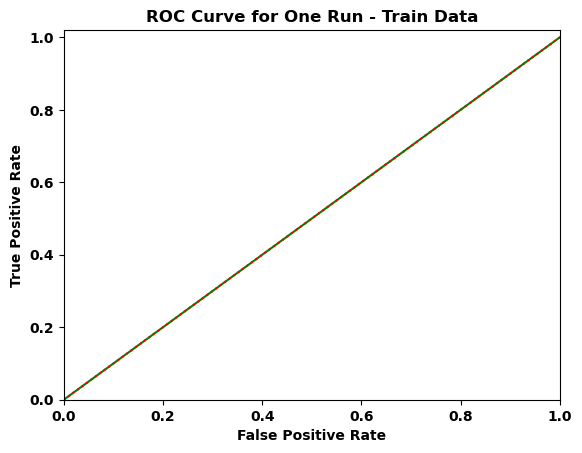

Confusion Matrix for Train Data
 [[286   0]
 [170   0]]



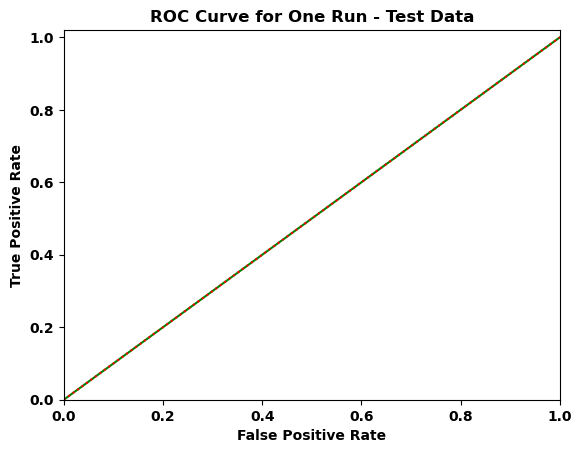

Confusion Matrix for Test Data
 [[71  0]
 [42  0]]


In [184]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
#     normalizer = Normalizer().fit(X_train)
#     X_test = normalizer.transform(X_test)
#     X_train = normalizer.transform(X_train)
#     scaler = StandardScaler().fit(X_train)
#     X_test = scaler.transform(X_test)
#     X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=1.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [185]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.9995614035087719


In [186]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7330345093502989
Average accuracy for test data: 0.6283185840707964


In [187]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.0
Average precision for test data: 0.0


In [188]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.0
Average recall for test data: 0.0


In [189]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.0
Average f1_score for test data: 0.0


In [190]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.5
Average AUC for test data: 0.5


First with raw data, gamma = 10

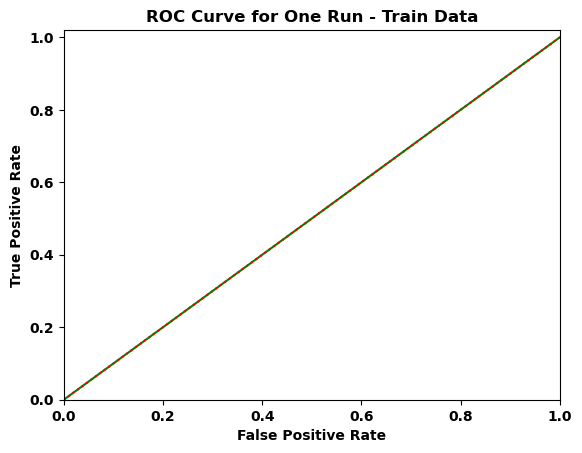

Confusion Matrix for Train Data
 [[286   0]
 [170   0]]



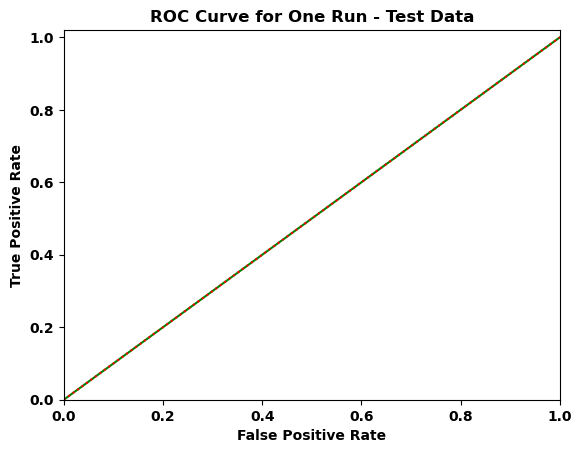

Confusion Matrix for Test Data
 [[71  0]
 [42  0]]


In [191]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
#     normalizer = Normalizer().fit(X_train)
#     X_test = normalizer.transform(X_test)
#     X_train = normalizer.transform(X_train)
#     scaler = StandardScaler().fit(X_train)
#     X_test = scaler.transform(X_test)
#     X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=10.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [192]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.9991228070175439


In [193]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7292945260678197
Average accuracy for test data: 0.6283185840707964


In [194]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.0
Average precision for test data: 0.0


In [195]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.0
Average recall for test data: 0.0


In [196]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.0
Average f1_score for test data: 0.0


In [197]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.5
Average AUC for test data: 0.5


First with raw data, gamma = 100

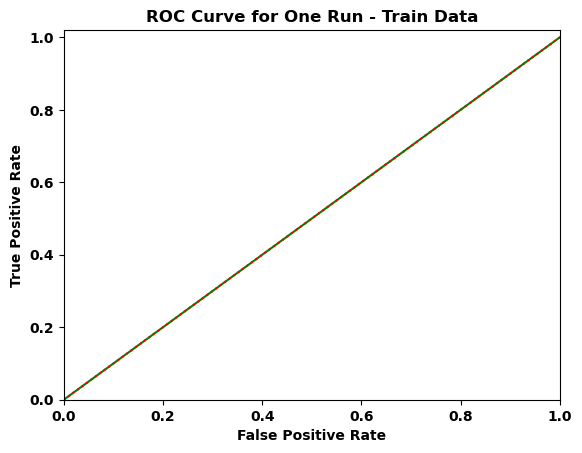

Confusion Matrix for Train Data
 [[286   0]
 [170   0]]



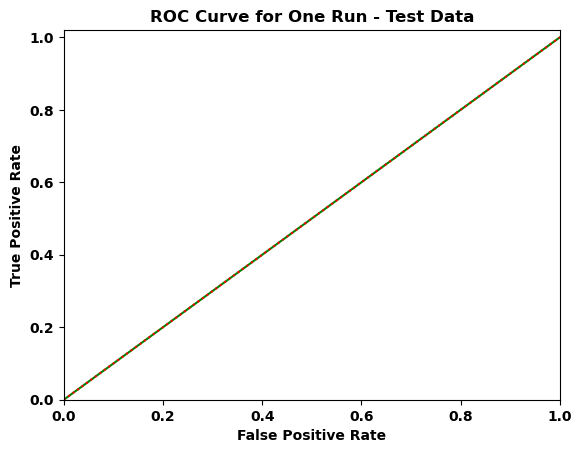

Confusion Matrix for Test Data
 [[71  0]
 [42  0]]


In [198]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
#     normalizer = Normalizer().fit(X_train)
#     X_test = normalizer.transform(X_test)
#     X_train = normalizer.transform(X_train)
#     scaler = StandardScaler().fit(X_train)
#     X_test = scaler.transform(X_test)
#     X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=100.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [199]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.575219298245614


In [200]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7258098317466019
Average accuracy for test data: 0.6283185840707964


In [201]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.0
Average precision for test data: 0.0


In [202]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.0
Average recall for test data: 0.0


In [203]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.0
Average f1_score for test data: 0.0


In [204]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.5
Average AUC for test data: 0.5


Now with normalized data, gamma = 1

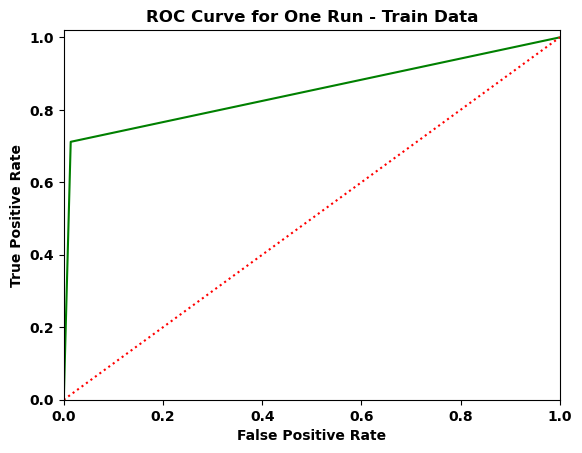

Confusion Matrix for Train Data
 [[282   4]
 [ 49 121]]



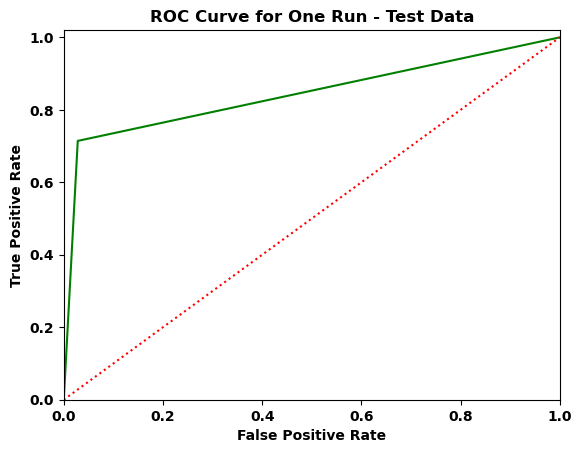

Confusion Matrix for Test Data
 [[69  2]
 [12 30]]


In [205]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
    normalizer = Normalizer().fit(X_train)
    X_test = normalizer.transform(X_test)
    X_train = normalizer.transform(X_train)
#     scaler = StandardScaler().fit(X_train)
#     X_test = scaler.transform(X_test)
#     X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=1.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [206]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.7258771929824561


In [207]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7309362515198888
Average accuracy for test data: 0.4265486725663717


In [208]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.9632250269069187
Average precision for test data: 0.45274329174809347


In [209]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.7082352941176471
Average recall for test data: 0.45476190476190476


In [210]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.8161273180203708
Average f1_score for test data: 0.43893697981890095


In [211]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.8460756890168655
Average AUC for test data: 0.43231052984574114


Now with normalized data, gamma = 10

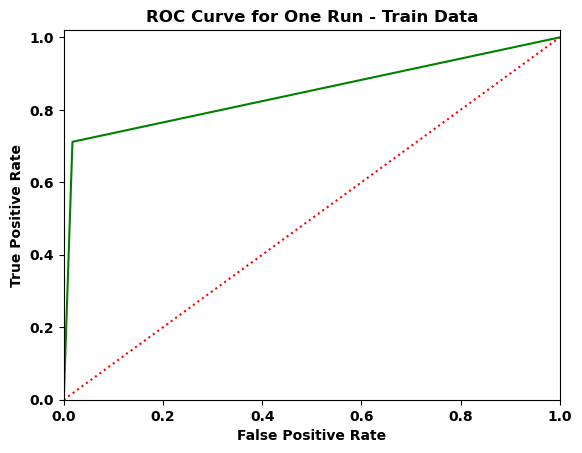

Confusion Matrix for Train Data
 [[281   5]
 [ 49 121]]



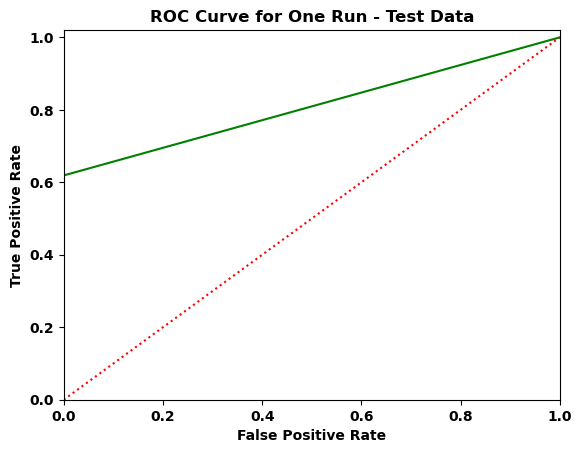

Confusion Matrix for Test Data
 [[71  0]
 [16 26]]


In [212]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
    normalizer = Normalizer().fit(X_train)
    X_test = normalizer.transform(X_test)
    X_train = normalizer.transform(X_train)
#     scaler = StandardScaler().fit(X_train)
#     X_test = scaler.transform(X_test)
#     X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=10.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [213]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.7375


In [214]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7354898828541001
Average accuracy for test data: 0.4929203539823009


In [215]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.9694124361451198
Average precision for test data: 0.5523090057489405


In [216]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.6823529411764706
Average recall for test data: 0.4714285714285714


In [217]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.8006255575638848
Average f1_score for test data: 0.48662876811583117


In [218]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.8347079391197039
Average AUC for test data: 0.48853118712273635


Now with normalized data, gamma = 100

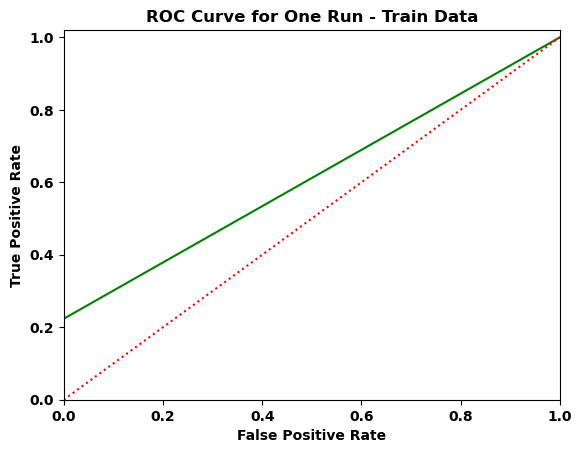

Confusion Matrix for Train Data
 [[286   0]
 [132  38]]



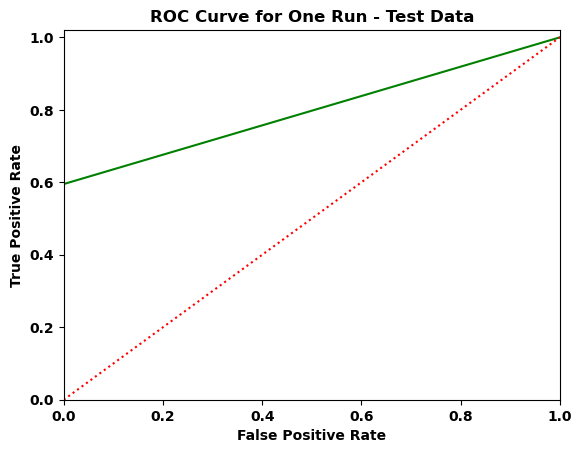

Confusion Matrix for Test Data
 [[71  0]
 [17 25]]


In [219]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
    normalizer = Normalizer().fit(X_train)
    X_test = normalizer.transform(X_test)
    X_train = normalizer.transform(X_train)
#     scaler = StandardScaler().fit(X_train)
#     X_test = scaler.transform(X_test)
#     X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=100.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [220]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.8921052631578947


In [221]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7354366954538049
Average accuracy for test data: 0.5079646017699115


In [222]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.9958740600531645
Average precision for test data: 0.6229507963497545


In [223]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.2876470588235294
Average recall for test data: 0.5142857142857142


In [224]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.4377780276309228
Average f1_score for test data: 0.4784026406574979


In [225]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.6432990538872891
Average AUC for test data: 0.5092555331991953


Now with standardized data, gamma = 1

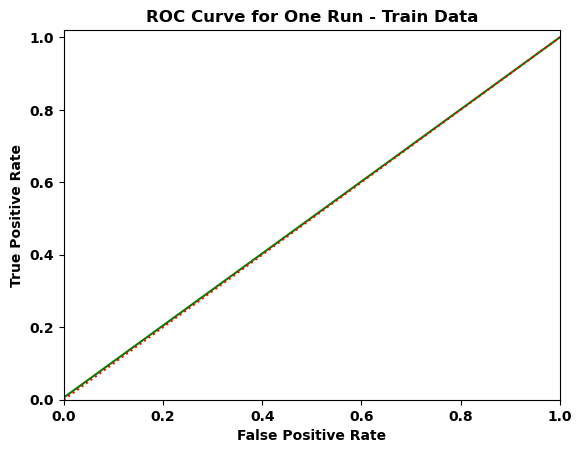

Confusion Matrix for Train Data
 [[286   0]
 [169   1]]



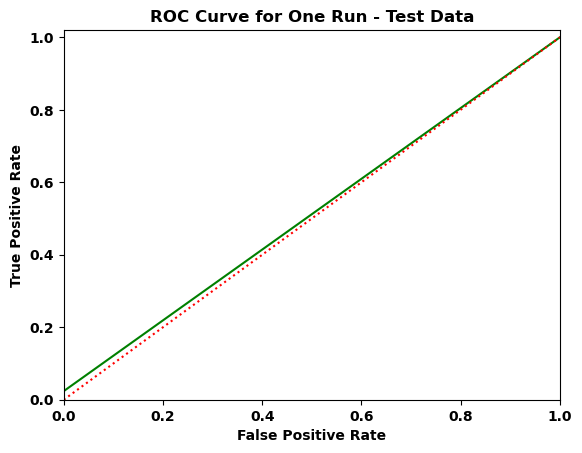

Confusion Matrix for Test Data
 [[71  0]
 [41  1]]


In [226]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
#     normalizer = Normalizer().fit(X_train)
#     X_test = normalizer.transform(X_test)
#     X_train = normalizer.transform(X_train)
    scaler = StandardScaler().fit(X_train)
    X_test = scaler.transform(X_test)
    X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=1.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [227]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.9962719298245615


In [228]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.732291502028344
Average accuracy for test data: 0.5920353982300885


In [229]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.9
Average precision for test data: 0.5101374570446736


In [230]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.009411764705882352
Average recall for test data: 0.0880952380952381


In [231]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.01861825105399157
Average f1_score for test data: 0.08553022698120573


In [232]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.5047058823529411
Average AUC for test data: 0.4891180415828303


Now with standardized data, gamma = 10

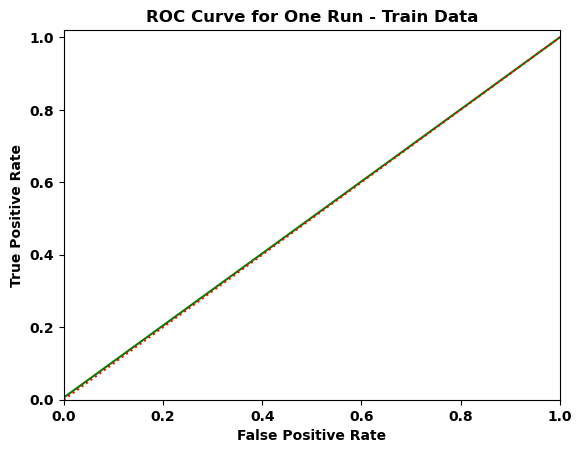

Confusion Matrix for Train Data
 [[286   0]
 [169   1]]



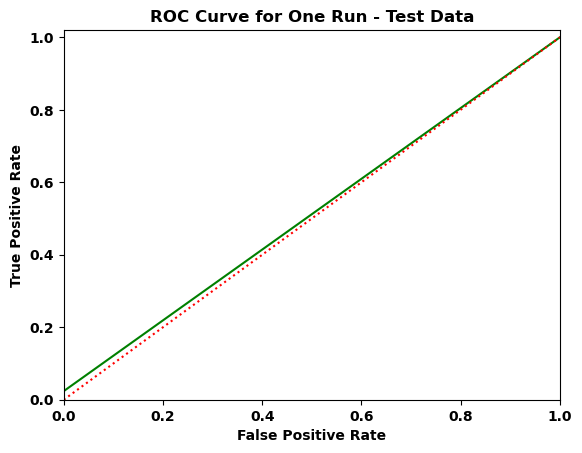

Confusion Matrix for Test Data
 [[71  0]
 [41  1]]


In [233]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
#     normalizer = Normalizer().fit(X_train)
#     X_test = normalizer.transform(X_test)
#     X_train = normalizer.transform(X_train)
    scaler = StandardScaler().fit(X_train)
    X_test = scaler.transform(X_test)
    X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=10.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [234]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.9967105263157896


In [235]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7293233082706766
Average accuracy for test data: 0.6300884955752213


In [236]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 1.0
Average precision for test data: 0.6


In [237]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.008823529411764707
Average recall for test data: 0.016666666666666666


In [238]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.017475860193118455
Average f1_score for test data: 0.032346723044397466


In [239]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.5044117647058823
Average AUC for test data: 0.5048122065727699


Now with standardized data, gamma = 100

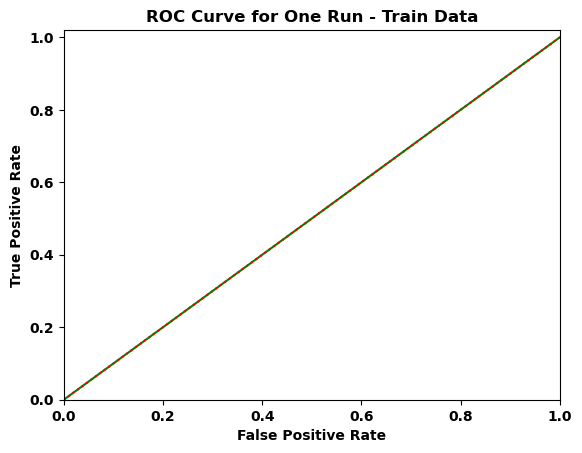

Confusion Matrix for Train Data
 [[286   0]
 [170   0]]



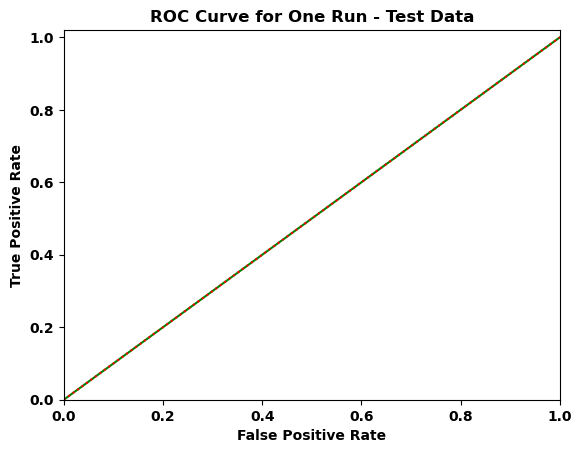

Confusion Matrix for Test Data
 [[71  0]
 [42  0]]


In [240]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
#     normalizer = Normalizer().fit(X_train)
#     X_test = normalizer.transform(X_test)
#     X_train = normalizer.transform(X_train)
    scaler = StandardScaler().fit(X_train)
    X_test = scaler.transform(X_test)
    X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=100.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [241]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.9997807017543859


In [242]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7264300979076587
Average accuracy for test data: 0.6283185840707964


In [243]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.0
Average precision for test data: 0.0


In [244]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.0
Average recall for test data: 0.0


In [245]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.0
Average f1_score for test data: 0.0


In [246]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.5
Average AUC for test data: 0.5


Now with normalized+standardized data, gamma = 1

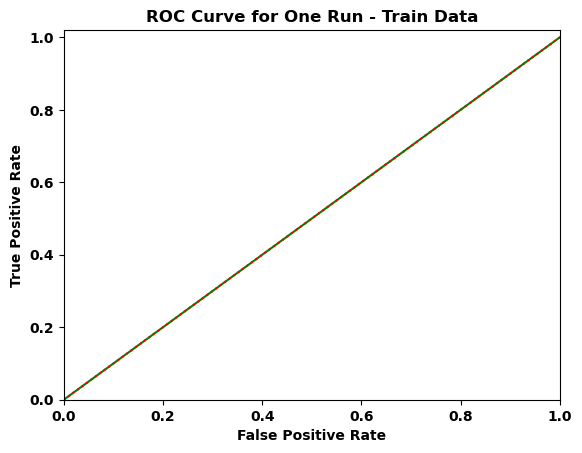

Confusion Matrix for Train Data
 [[286   0]
 [170   0]]



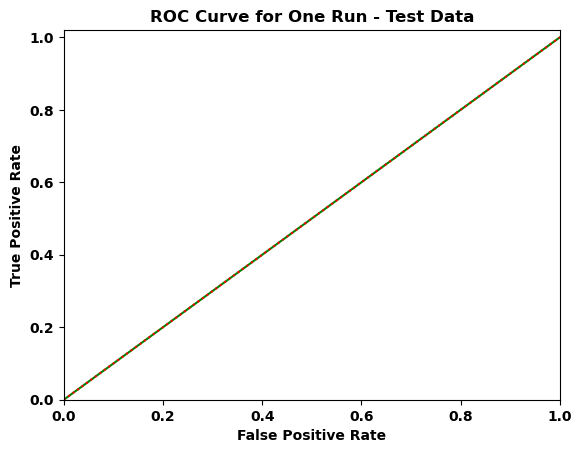

Confusion Matrix for Test Data
 [[71  0]
 [42  0]]


In [247]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
    normalizer = Normalizer().fit(X_train)
    X_test = normalizer.transform(X_test)
    X_train = normalizer.transform(X_train)
    scaler = StandardScaler().fit(X_train)
    X_test = scaler.transform(X_test)
    X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=1.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [248]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.9964912280701755


In [249]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7236962930742835
Average accuracy for test data: 0.6283185840707964


In [250]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.0
Average precision for test data: 0.0


In [251]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.0
Average recall for test data: 0.0


In [252]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.0
Average f1_score for test data: 0.0


In [253]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.5
Average AUC for test data: 0.5


Now with normalized+standardized data, gamma = 10

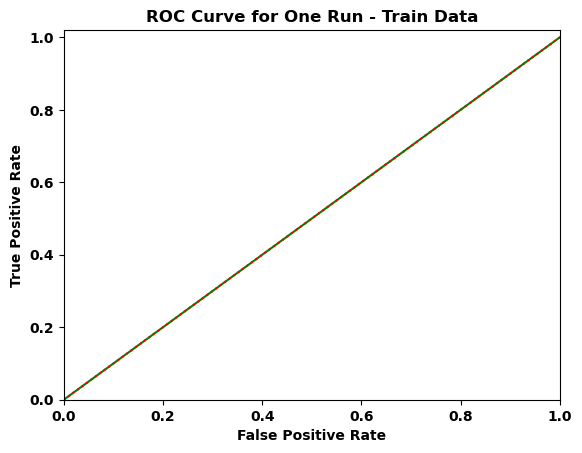

Confusion Matrix for Train Data
 [[286   0]
 [170   0]]



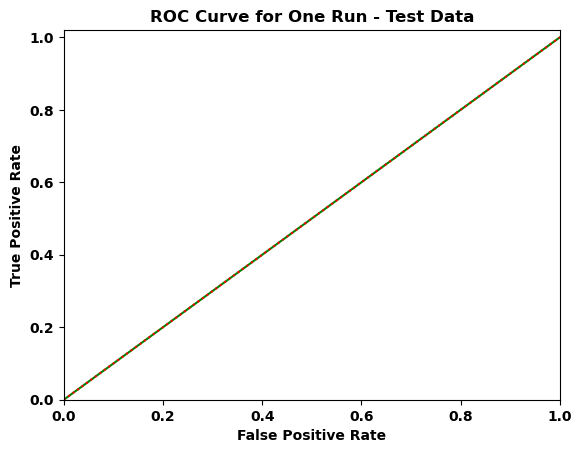

Confusion Matrix for Test Data
 [[71  0]
 [42  0]]


In [254]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
#     normalizer = Normalizer().fit(X_train)
#     X_test = normalizer.transform(X_test)
#     X_train = normalizer.transform(X_train)
#     scaler = StandardScaler().fit(X_train)
#     X_test = scaler.transform(X_test)
#     X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=10.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [255]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.9982456140350877


In [256]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7211090729504727
Average accuracy for test data: 0.6283185840707964


In [257]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.0
Average precision for test data: 0.0


In [258]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.0
Average recall for test data: 0.0


In [259]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.0
Average f1_score for test data: 0.0


In [260]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.5
Average AUC for test data: 0.5


Now with normalized+standardized data, gamma = 100

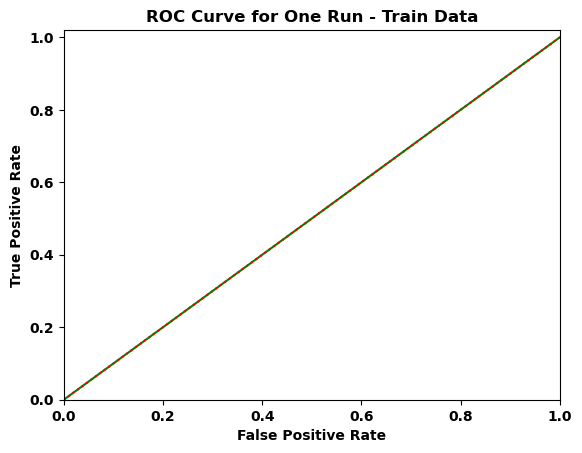

Confusion Matrix for Train Data
 [[286   0]
 [170   0]]



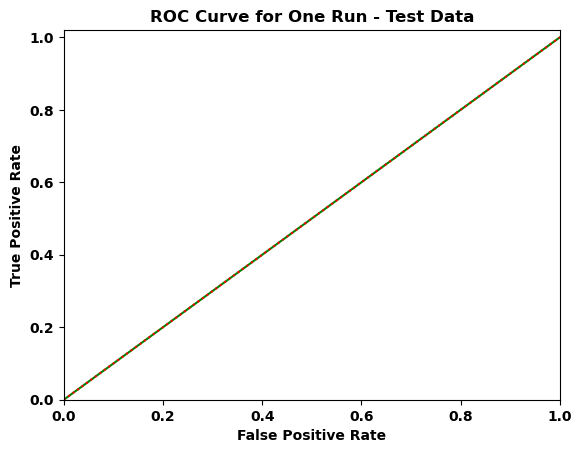

Confusion Matrix for Test Data
 [[71  0]
 [42  0]]


In [261]:
# accuracy_train = []
precision_train = []
recall_train = []
f1_score_train = []
auc_train = []
cluster_ratio_train = []

accuracy_test = []
precision_test = []
recall_test = []
f1_score_test = []
auc_test = []

for i in range(10):
    
    #randomly sample rows to create raw test/train sets
    df1_test = pd.concat([df1_m.sample(int(len(df1_m.index)*.2)), df1_b.sample(int(len(df1_b.index)*.2))], axis=0)
    df1_train = df1.drop(df1_test.index)
    X_test = df1_test.iloc[:,1:]
    y_test = df1_test[1]
    X_train = df1_train.iloc[:,1:]
    y_train = df1_train[1]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    #normalize and standardize test/train data
#     normalizer = Normalizer().fit(X_train)
#     X_test = normalizer.transform(X_test)
#     X_train = normalizer.transform(X_train)
#     scaler = StandardScaler().fit(X_train)
#     X_test = scaler.transform(X_test)
#     X_train = scaler.transform(X_train)

    #make sure you initialize the algorithm randomly
    clusterer = SpectralClustering(n_clusters=2, gamma=100.0, affinity='rbf', n_init=10, random_state=rand_list[i])
    cluster_labels = clusterer.fit_predict(X_train)
    cluster_labels = pd.DataFrame(cluster_labels)
    cluster_labels['true values'] = y_train
    cluster_labels_0 = cluster_labels[cluster_labels[0]==0]
    max_cluster_label_0 = cluster_labels_0['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_labels_1 = cluster_labels[cluster_labels[0]==1]
    max_cluster_label_1 = -1
    if cluster_labels_1.empty:
        max_cluster_label_1 = max_cluster_label_0
    else:
        max_cluster_label_1 = cluster_labels_1['true values'].value_counts().sort_values(ascending=False).index[0]
    cluster_ratio = len(cluster_labels_0)/(len(cluster_labels_0)+len(cluster_labels_1))
    cluster_ratio_train.append(max(cluster_ratio,1-cluster_ratio))
    majority_poll_cluster_label = [max_cluster_label_0, max_cluster_label_1]

    #for all the training data points predicted to cluster [0], we assign it majority_poll_cluster_label[0], 
    #and likewise for cluster [1]
    y_train_pred = clusterer.fit_predict(X_train)
    pred_labels = pd.DataFrame(y_train_pred)
    pred_labels_0 = pred_labels[pred_labels[0]==0]
    pred_labels_1 = pred_labels[pred_labels[0]==1]
    pred_labels_0['class'] = majority_poll_cluster_label[0]
    pred_labels_1['class'] = majority_poll_cluster_label[1]
    y_train_pred = pd.concat([pred_labels_0['class'],pred_labels_1['class']],axis=0).sort_index()

    #test data
    y_test_pred = clusterer.fit_predict(X_test)
    pred_labels_test = pd.DataFrame(y_test_pred)
    pred_labels_test_0 = pred_labels_test[pred_labels_test[0]==0]
    pred_labels_test_1 = pred_labels_test[pred_labels_test[0]==1]
    pred_labels_test_0['class'] = majority_poll_cluster_label[0]
    pred_labels_test_1['class'] = majority_poll_cluster_label[1]
    y_test_pred = pd.concat([pred_labels_test_0['class'],pred_labels_test_1['class']],axis=0).sort_index()
    
    #report metrics
    accuracy_train.append(accuracy_score(y_train,y_train_pred)) #accuracy
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
    precision_train.append(precision_score(y_train,y_train_pred)) #precision
    precision_test.append(precision_score(y_test,y_test_pred))
    recall_train.append(recall_score(y_train,y_train_pred)) #recall
    recall_test.append(recall_score(y_test,y_test_pred))
    f1_score_train.append(f1_score(y_train,y_train_pred)) #f1-score
    f1_score_test.append(f1_score(y_test,y_test_pred))
    
    fpr,tpr,thres = roc_curve(y_train,y_train_pred) #auc
    auc_train.append(auc(fpr,tpr))
    fpr,tpr,thres = roc_curve(y_test,y_test_pred)
    auc_test.append(auc(fpr,tpr))
    
    #Plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 0:
        fpr,tpr,thres = roc_curve(y_train,y_train_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Train Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Train Data\n',confusion_matrix(y_train,y_train_pred))
        print()
        
        fpr,tpr,thres = roc_curve(y_test,y_test_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='green')
        plt.plot([0, 1], [0, 1], color='red', linestyle=':')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for One Run - Test Data')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.show()
        plt.close()
        print('Confusion Matrix for Test Data\n',confusion_matrix(y_test,y_test_pred))

In [262]:
print('Average cluster ratio for train data:', str(np.mean(cluster_ratio_train)))

Average cluster ratio for train data: 0.5868421052631578


In [263]:
print('Average accuracy for train data:',str(np.mean(accuracy_train)))
print('Average accuracy for test data:',str(np.mean(accuracy_test)))

Average accuracy for train data: 0.7186569557051897
Average accuracy for test data: 0.6283185840707964


In [264]:
print('Average precision for train data:',str(np.mean(precision_train)))
print('Average precision for test data:',str(np.mean(precision_test)))

Average precision for train data: 0.0
Average precision for test data: 0.0


In [265]:
print('Average recall for train data:',str(np.mean(recall_train)))
print('Average recall for test data:',str(np.mean(recall_test)))

Average recall for train data: 0.0
Average recall for test data: 0.0


In [266]:
print('Average f1_score for train data:',str(np.mean(f1_score_train)))
print('Average f1_score for test data:',str(np.mean(f1_score_test)))

Average f1_score for train data: 0.0
Average f1_score for test data: 0.0


In [267]:
print('Average AUC for train data:',str(np.mean(auc_train)))
print('Average AUC for test data:',str(np.mean(auc_test)))

Average AUC for train data: 0.5
Average AUC for test data: 0.5
